In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import librosa
import os
from sklearn.model_selection import train_test_split



In [ ]:
# 1. Data Loading and Preprocessing

def load_audio(file_path, sr=16000):
    audio, _ = librosa.load(file_path, sr=sr)
    return audio

def load_dataset(clean_folder, noisy_folder, sr=16000, duration=5):
    clean_files = sorted([f for f in os.listdir(clean_folder) if f.endswith('.wav')])
    noisy_files = sorted([f for f in os.listdir(noisy_folder) if f.endswith('.wav')])

    X = []
    y = []

    for clean_file, noisy_file in zip(clean_files, noisy_files):
        clean_audio = load_audio(os.path.join(clean_folder, clean_file), sr)
        noisy_audio = load_audio(os.path.join(noisy_folder, noisy_file), sr)

        # Ensure both audios have the same length
        min_length = min(len(clean_audio), len(noisy_audio))
        clean_audio = clean_audio[:min_length]
        noisy_audio = noisy_audio[:min_length]

        X.append(noisy_audio)
        y.append(clean_audio)

    # Pad all audio to the same length
    max_length = max(len(audio) for audio in X)
    X = [np.pad(audio, (0, max_length - len(audio))) for audio in X]
    y = [np.pad(audio, (0, max_length - len(audio))) for audio in y]

    return np.array(X), np.array(y)

# Load the dataset
clean_folder = 'data/processed_audio/clean'
noisy_folder = 'data/processed_audio/noisy'
X, y = load_dataset(clean_folder, noisy_folder)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], -1, 1)
y_train = y_train.reshape(y_train.shape[0], -1, 1)
X_val = X_val.reshape(X_val.shape[0], -1, 1)
y_val = y_val.reshape(y_val.shape[0], -1, 1)


In [3]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (288, 80000, 1)
y_train shape: (288, 80000, 1)


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_waveforms(clean, noisy, noise, index):
    fig, axs = plt.subplots(3, 1, figsize=(20, 15))
    fig.suptitle(f'Audio Pair {index + 1}', fontsize=16)

    # Clean Audio Waveform
    axs[0].plot(clean, linewidth=0.5)
    axs[0].set_title('Clean Audio Waveform')
    axs[0].set_xlabel('Sample')
    axs[0].set_ylabel('Amplitude')
    axs[0].set_ylim(-1, 1)

    # Noise Waveform
    axs[1].plot(noise, linewidth=0.5)
    axs[1].set_title('Noise Waveform')
    axs[1].set_xlabel('Sample')
    axs[1].set_ylabel('Amplitude')
    axs[1].set_ylim(-1, 1)

    # Noisy Audio Waveform
    axs[2].plot(noisy, linewidth=0.5)
    axs[2].set_title('Noisy Audio Waveform')
    axs[2].set_xlabel('Sample')
    axs[2].set_ylabel('Amplitude')
    axs[2].set_ylim(-1, 1)

    plt.tight_layout()
    plt.savefig(f'audio_pair_waveforms_{index + 1}.png', dpi=300)
    plt.close()

# Assuming X_train contains noisy audio and y_train contains clean audio
# You'll need to calculate the noise as the difference between noisy and clean

# Select 3 random indices
sample_indices = np.random.choice(X_train.shape[0], 3, replace=False)

for i, idx in enumerate(sample_indices):
    clean = y_train[idx].squeeze()
    noisy = X_train[idx].squeeze()
    noise = noisy - clean  # This assumes the noise is additive
    
    # Normalize the waveforms to [-1, 1] range
    clean = clean / np.max(np.abs(clean))
    noisy = noisy / np.max(np.abs(noisy))
    noise = noise / np.max(np.abs(noise))
    
    plot_waveforms(clean, noisy, noise, i)

print("Waveforms have been saved as PNG files.")

Waveforms have been saved as PNG files.


In [5]:
def extract_features(audio):
    # Compute STFT
    D = librosa.stft(audio, n_fft=256, hop_length=64, win_length=256)
    
    # Compute magnitude spectrogram
    S = np.abs(D)
    
    # Extract features
    spectral_centroid = librosa.feature.spectral_centroid(S=S)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(S=S)
    spectral_rolloff = librosa.feature.spectral_rolloff(S=S)
    
    return {
        "Mean Magnitude": np.mean(S),
        "Std Magnitude": np.std(S),
        "Mean Spectral Centroid": np.mean(spectral_centroid),
        "Mean Spectral Bandwidth": np.mean(spectral_bandwidth),
        "Mean Spectral Rolloff": np.mean(spectral_rolloff)
    }
clean_sample = y_train[0].squeeze()
noisy_sample = X_train[0].squeeze()
clean_features = extract_features(clean_sample)
noisy_features = extract_features(noisy_sample)

print("Clean Audio Features:")
for key, value in clean_features.items():
    print(f"{key}: {value:.4f}")

print("\nNoisy Audio Features:")
for key, value in noisy_features.items():
    print(f"{key}: {value:.4f}")

Clean Audio Features:
Mean Magnitude: 0.0626
Std Magnitude: 0.2914
Mean Spectral Centroid: 1816.6147
Mean Spectral Bandwidth: 1905.8317
Mean Spectral Rolloff: 3648.0103

Noisy Audio Features:
Mean Magnitude: 0.0858
Std Magnitude: 0.3720
Mean Spectral Centroid: 1713.4719
Mean Spectral Bandwidth: 1737.6155
Mean Spectral Rolloff: 3270.5682


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

def make_generator_model():
    inputs = layers.Input(shape=(80000, 1))
    
    # Encoder
    x = layers.Conv1D(16, 32, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1D(32, 32, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1D(64, 32, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1D(128, 32, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1D(256, 32, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    
    # Decoder
    x = layers.Conv1DTranspose(128, 32, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1DTranspose(64, 32, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1DTranspose(32, 32, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1DTranspose(16, 32, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    
    outputs = layers.Conv1DTranspose(1, 32, strides=2, padding='same', activation='tanh')(x)
    
    return models.Model(inputs, outputs)

def make_discriminator_model():
    inputs = layers.Input(shape=(80000, 1))
    
    x = layers.Conv1D(16, 32, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1D(32, 32, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1D(64, 32, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1D(128, 32, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1D(256, 32, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1)(x)
    
    return models.Model(inputs, outputs)




@tf.keras.utils.register_keras_serializable()
class SEGAN(keras.Model):
    def __init__(self):
        super(SEGAN, self).__init__()
        self.generator = make_generator_model()
        self.discriminator = make_discriminator_model()
    
    def call(self, inputs):
        return self.generator(inputs)
    
    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(SEGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
    
    def train_step(self, data):
        noisy, clean = data
        
        # Train Discriminator
        with tf.GradientTape() as tape:
            fake_clean = self.generator(noisy, training=True)
            real_output = self.discriminator(clean, training=True)
            fake_output = self.discriminator(fake_clean, training=True)
            d_loss = self.loss_fn(tf.ones_like(real_output), real_output) + \
                     self.loss_fn(tf.zeros_like(fake_output), fake_output)
        
        d_gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))
        
        # Train Generator
        with tf.GradientTape() as tape:
            fake_clean = self.generator(noisy, training=True)
            fake_output = self.discriminator(fake_clean, training=True)
            g_loss = self.loss_fn(tf.ones_like(fake_output), fake_output) + \
                     100 * tf.reduce_mean(tf.abs(clean - fake_clean))  # L1 loss
        
        g_gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))
        
        return {"d_loss": d_loss, "g_loss": g_loss}

    def get_config(self):
        return {}

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# Create and compile the model
model2 = SEGAN()
model2.compile(
    g_optimizer=tf.keras.optimizers.Adam(1e-4),
    d_optimizer=tf.keras.optimizers.Adam(1e-4),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

# Prepare the dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(16)

# Train the model
history = model2.fit(train_dataset, epochs=100)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 174s 9s/step - d_loss: 1.3468 - g_loss: 2.1500
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 154s 9s/step - d_loss: 1.3401 - g_loss: 1.7661
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 172s 10s/step - d_loss: 1.3657 - g_loss: 1.7942
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 185s 10s/step - d_loss: 1.4942 - g_loss: 2.0359
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 166s 9s/step - d_loss: 1.4217 - g_loss: 1.6499
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - d_loss: 1.3236 - g_loss: 1.6514
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 175s 10s/step - d_loss: 1.2183 - g_loss: 1.5842
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 169s 9s/step - d_loss: 1.7173 - g_loss: 1.7741
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 167s 9s/step - d_loss: 1.3951 - g_loss: 1.6759
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 158s 9s/step - d_loss: 1.3804 - g_loss: 1.4555
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 174s 10s/step - d_loss: 1.3788 - g_loss: 1.4191
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 180s 10s

In [ ]:
# After training
model2.save('audioDenoiserModel2.keras', save_format='keras')

/Users/whales_mac/Desktop/wave_u_net denoiser/myenv/lib/python3.10/site-packages/keras/src/saving/saving_api.py:102: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [12]:
tf.keras.models.save_model(model2, 'new_segan_model.keras', save_format='keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


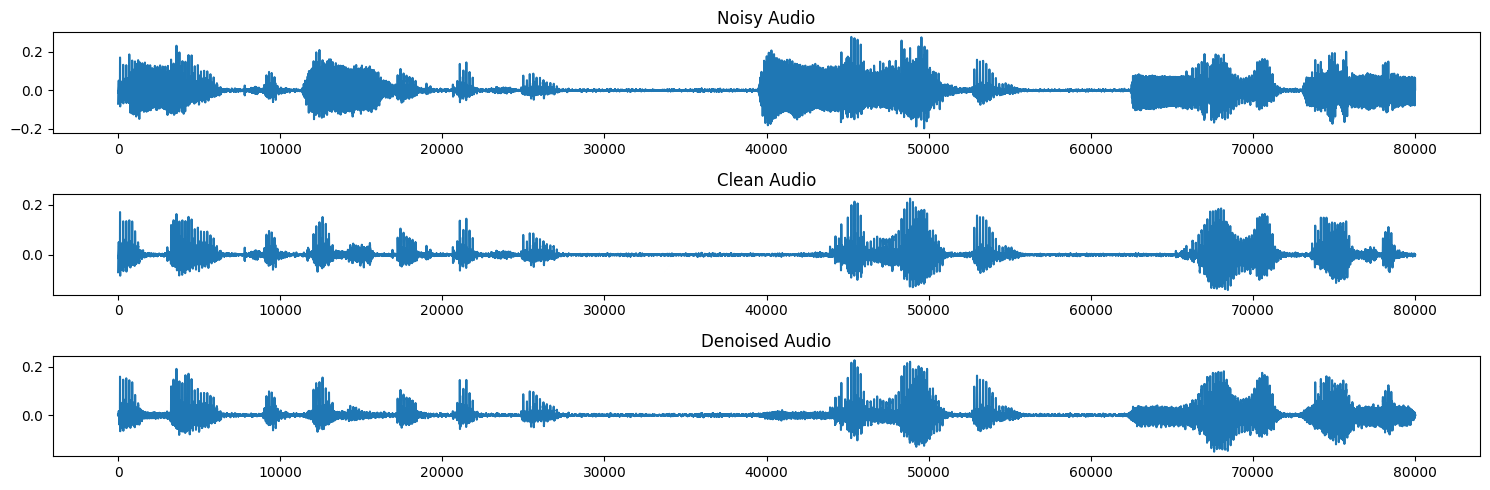

In [10]:

# 4. Evaluation

# Plot training history
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# Function to denoise audio
def denoise_audio(audio, model2):
    # Reshape audio to match model input
    audio_input = audio.reshape(1, -1, 1)

    # Predict
    denoised = model2.predict(audio_input)

    # Reshape back to 1D
    return denoised.reshape(-1)

# Test on a validation sample
test_index = 0
noisy_audio = X_val[test_index]
clean_audio = y_val[test_index]
denoised_audio = denoise_audio(noisy_audio, model2)

# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(311)
plt.title("Noisy Audio")
plt.plot(noisy_audio)
plt.subplot(312)
plt.title("Clean Audio")
plt.plot(clean_audio)
plt.subplot(313)
plt.title("Denoised Audio")
plt.plot(denoised_audio)
plt.tight_layout()
plt.show()

# Optionally, save audio files
# import soundfile as sf

# sf.write('noisy.wav', noisy_audio, 16000)
# sf.write('clean.wav', clean_audio, 16000)
# sf.write('denoised.wav', denoised_audio, 16000)

In [14]:
import numpy as np
from pesq import pesq
from pystoi import stoi
import soundfile as sf

def spectral_gate(audio, threshold_db=-30, reduction_db=-12):
    S = librosa.stft(audio)
    S_db = librosa.amplitude_to_db(np.abs(S))
    mask = S_db > threshold_db
    S_reduced = S * mask + S * (1 - mask) * (10 ** (reduction_db / 20))
    return librosa.istft(S_reduced)

def calculate_snr(clean, noisy):
    noise = clean - noisy
    return 10 * np.log10(np.sum(clean**2) / np.sum(noise**2))

def evaluate_audio(clean, noisy, denoised, sr=16000):
    # Calculate SNR
    noisy_snr = calculate_snr(clean, noisy)
    denoised_snr = calculate_snr(clean, denoised)
    
    # Calculate PESQ
    noisy_pesq = pesq(sr, clean, noisy, 'nb')
    denoised_pesq = pesq(sr, clean, denoised, 'nb')
    
    # Calculate STOI
    noisy_stoi = stoi(clean, noisy, sr, extended=False)
    denoised_stoi = stoi(clean, denoised, sr, extended=False)
    
    return {
        'SNR': {'noisy': noisy_snr, 'denoised': denoised_snr},
        'PESQ': {'noisy': noisy_pesq, 'denoised': denoised_pesq},
        'STOI': {'noisy': noisy_stoi, 'denoised': denoised_stoi}
    }


# ... (keep your existing code for model loading and metric calculations)

# Define a function to save audio
def save_audio(audio, filename, sr=16000):
    sf.write(filename, audio, sr)

# Take 5 samples from the validation set
for i in range(10):
    noisy = X_train[i].squeeze()  # Remove any extra dimensions
    clean = y_train[i].squeeze()
    
    # Make prediction (denoise)
    denoised = model2.predict(noisy[np.newaxis, ..., np.newaxis]).squeeze()


    # Apply after model prediction
    # denoised = spectral_gate(denoised)
    
    # Evaluate
    result = evaluate_audio(clean, noisy, denoised)
    
    # Print results
    print(f"Sample {i+1}")
    print(f"SNR - Noisy: {result['SNR']['noisy']:.2f} dB, Denoised: {result['SNR']['denoised']:.2f} dB")
    print(f"PESQ - Noisy: {result['PESQ']['noisy']:.2f}, Denoised: {result['PESQ']['denoised']:.2f}")
    print(f"STOI - Noisy: {result['STOI']['noisy']:.2f}, Denoised: {result['STOI']['denoised']:.2f}")
    print("---")

    # Save the noisy, clean, and denoised audio
    save_audio(noisy, f'noisy_sample_{i+1}.wav')
    save_audio(clean, f'clean_sample_{i+1}.wav')
    save_audio(denoised, f'denoised_sample_{i+1}.wav')


    from IPython.display import Audio, display

# After saving the files, you can play them like this:
for i in range(10):
    print(f"Sample {i+1}")
    print("Noisy:")
    display(Audio(f'noisy_sample_{i+1}.wav'))
    print("Denoised:")
    display(Audio(f'denoised_sample_{i+1}.wav'))
    print("Clean:")
    display(Audio(f'clean_sample_{i+1}.wav'))
    print("---")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Sample 1
SNR - Noisy: 1.91 dB, Denoised: 12.56 dB
PESQ - Noisy: 2.64, Denoised: 2.66
STOI - Noisy: 0.77, Denoised: 0.71
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Sample 2
SNR - Noisy: 5.28 dB, Denoised: 12.90 dB
PESQ - Noisy: 2.61, Denoised: 2.99
STOI - Noisy: 0.83, Denoised: 0.72
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Sample 3
SNR - Noisy: 3.67 dB, Denoised: 13.27 dB
PESQ - Noisy: 1.93, Denoised: 2.69
STOI - Noisy: 0.81, Denoised: 0.70
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Sample 4
SNR - Noisy: 4.46 dB, Denoised: 11.43 dB
PESQ - Noisy: 1.86, Denoised: 2.40
STOI - Noisy: 0.67, Denoised: 0.73
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Sample 5
SNR - Noisy: 5.11 dB, Denoised: 13.25 dB
PESQ - Noisy: 2.19, Denoised: 2.34
STOI - Noisy: 0.81, Denoised: 0.67
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Sample 6
SNR - Noisy: 1.72 dB, Denoised: 11.87 dB
PESQ - Noisy: 2.80, Denoised: 2.85
STOI - Noisy: 0.75, Denoised: 0.72
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Denoised:


Clean:


---
Sample 2
Noisy:


Denoised:


Clean:


---
Sample 3
Noisy:


Denoised:


Clean:


---
Sample 4
Noisy:


Denoised:


Clean:


---
Sample 5
Noisy:


Denoised:


Clean:


---
Sample 6
Noisy:


Denoised:


Clean:


---
Sample 7
Noisy:


Denoised:


Clean:


---
Sample 8
Noisy:


Denoised:


Clean:


---
Sample 9
Noisy:


Denoised:


Clean:


---
Sample 10
Noisy:


Denoised:


Clean:


---


In [ ]:
import streamlit as st
import numpy as np
import soundfile as sf
import librosa
import io
from scipy.io.wavfile import write
import tensorflow as tf

# Load your pre-trained model
model = tf.keras.models.load_model('/Users/whales_mac/Desktop/wave_u_net denoiser/audio_denoiser_model2.keras')

# Function to preprocess the audio
def preprocess_audio(audio, sr=16000):
    # Resample if necessary
    if sr != 16000:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)
    # Convert to the format your model expects, e.g., STFT or raw waveform
    # Here, assuming a simple raw waveform input
    audio = np.expand_dims(audio, axis=0)
    return audio

# Function to denoise audio using the model
def denoise_audio(audio):
    processed_audio = preprocess_audio(audio)
    denoised_audio = model.predict(processed_audio)
    return np.squeeze(denoised_audio)

# Streamlit app
st.title('Audio Denoising with SEGAN')
st.write("Upload or record a noisy audio file, and the app will denoise it using the pre-trained SEGAN model.")

# Option to upload audio file
uploaded_file = st.file_uploader("Upload a noisy audio file", type=["wav", "mp3"])

# Option to record audio
recorded_audio = st.audio_input("Record noisy audio", format="wav")

# Process uploaded audio file
if uploaded_file is not None:
    audio, sr = librosa.load(uploaded_file, sr=None)
    st.audio(uploaded_file, format='audio/wav')

    # Denoise the audio
    denoised_audio = denoise_audio(audio)
    
    # Play denoised audio
    st.write("Denoised Audio:")
    st.audio(io.BytesIO(librosa.output.write_wav(io.BytesIO(), denoised_audio, sr=16000)), format="audio/wav")

# Process recorded audio
if recorded_audio is not None:
    audio, sr = librosa.load(recorded_audio, sr=None)
    st.audio(recorded_audio, format='audio/wav')

    # Denoise the audio
    denoised_audio = denoise_audio(audio)
    
    # Play denoised audio
    st.write("Denoised Audio:")
    st.audio(io.BytesIO(librosa.output.write_wav(io.BytesIO(), denoised_audio, sr=16000)), format="audio/wav")

# Option to download the denoised audio file
if st.button("Download Denoised Audio"):
    denoised_audio_wav = io.BytesIO()
    write(denoised_audio_wav, 16000, denoised_audio)
    st.download_button(label="Download", data=denoised_audio_wav, file_name="denoised_audio.wav", mime="audio/wav")

TypeError: Could not locate class 'SEGAN'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'SEGAN', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'SEGAN', 'compile_config': {'loss': None, 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}